# invert the saved results
- we have saved FOV->exvivo results 
- now we will load all the results and apply the invert transformation 
- and save the original coordinates in csv files

In [2]:

from datetime import date
import tifffile, pickle, napari, pprint
import sys, glob
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)
import scipy.ndimage as ndi

sys.path.append('./functions/')
from plotting import *

071324


# the original transformation was this: 
- started with FOV $X$ (and corresponding spots in FOV space $x$)
- the final product is $Y =T_1 \big( T_2(X)\big)$
    - $T_1$ is to map invivo to exvivo
    - $T_2$ is to map FOV to invivo
- therefore $X =T_2^{-1} \big( T_1^{-1}(Y)\big) $
- we call $T_1$ and $T_2$ `bhat1` and `bhat2`
# steps 
1. load transformed coordinates `y`
2. map back `y` to original invivo space ($T_1^{-1}(Y)$) -- `q`
3. map back `q` to original FOV space ( $T_2^{-1} \big( T_1^{-1}(Y)\big) $) -- `hp`
4. save csv

## 0. helpful functions

In [4]:
def get_orig_bhat(T_dict):
    B = np.eye(4)
    for l in T_dict:
        for k,v in l.items():
            if k=='bhat':
                B = B@((np.c_[v, np.array((0,0,0,1))]))
            if k=='scale':
                B[:,:3] *= v  
    return(B[:,:3])

## 1. load transformed results 
(from `refine_FOV_to_exvivo`)

In [5]:
base_dir='set_your_base_dir'

In [6]:
foo = pickle.load(open(base_dir + 'transformed_fov_11_12_070924.pkl','rb'))
y = foo['invivo points']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(800.0, 1100.0)

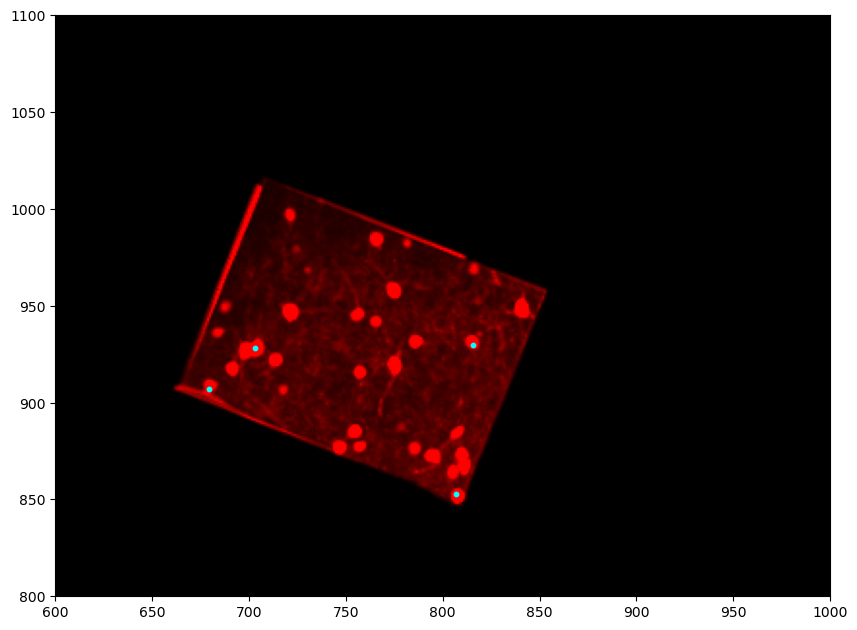

In [8]:
plt.figure(figsize = (10,10));plt.imshow(gray2RGB(foo['transformed tomato'],'r',scl=.1))
plt.scatter(y[:,2],y[:,1], color='cyan', s = 10)
plt.xlim(600,1000);plt.ylim(800,1100)

## 2. get `q` by $T_1^{-1}(Y)$

In [9]:
transformed_rez_path = base_dir + f'transformed_062024.pkl'
T_in_ex = pickle.load(open(transformed_rez_path, 'rb'))['transformations']
bhat1 = get_orig_bhat(T_in_ex)

In [10]:
q = (np.linalg.inv(bhat1[:3,:3].T)@y.T - np.linalg.inv(bhat1[:3,:3].T)@bhat1[-1][:,None]).T


## 3. get `h` by $T_2^{-1} \big( T_1^{-1}(Y)\big)$
- but first need to rearrange the coordinates of `q`
- then get `h` but then rearrange back the coordinates to get `hq`
- this is done by `T_fov_in` which was from this notebook `FOV_to_invivo`

In [11]:
filenames = [f.split('/')[-1] for f in glob.glob(base_dir+'Stacked*.tif')]

In [12]:
filenames  # should show all the averaged FOV files you have

['Stacked_ch2_movie_FOV11_12_zstack_1100nm_3x_.tif']

In [ ]:
# choose your FOV file. 
i = 0

In [13]:

transformedFOV_path = base_dir
savefilepath = transformedFOV_path+f'/FOV_{filenames[i]}_mapped_to_exvivo_2xds.pkl'
fov_t, T_fov_in = pickle.load(open(savefilepath,'rb'))

T_fov_in_list = list()
R = np.zeros((4,3))
for k,v in T_fov_in.items():    
    if k == 'shift_scale':
        T_fov_in_list.append({'scale':1/v})
    if k =='R':
        R[:3,:3]=np.linalg.inv(v)
    if k =='total_shift':        
        R[-1,:3]= np.array((v[1],v[2],v[0]))  # total shift has different orders. 
T_fov_in_list.append({'bhat':R})


bhat2 = get_orig_bhat(T_fov_in_list)  # note these guys have the order on (X,Y,Z)

In [14]:
qp = np.c_[(q[:,1],q[:,2],q[:,0])]  # now is XYZ
h = (np.linalg.inv(bhat2[:3,:3].T)@qp.T - np.linalg.inv(bhat2[:3,:3].T)@bhat2[-1][:,None]).T
hp = np.c_[(h[:,2],h[:,0],h[:,1])]  # now is ZXY


# 4. overlap with the original to check 

In [15]:
from skimage.transform import rescale

In [ ]:
# load the original FOV for checking

orig_fov = tifffile.imread(base_dir+filenames[i])
resolution = np.array((1,0.631,0.625))  # these are um/pix
data = rescale(orig_fov,resolution)
data = ndi.zoom(data,1/2)    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


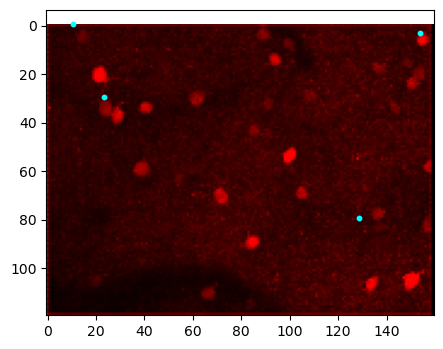

In [28]:

plt.figure(figsize = (5,5));plt.imshow(gray2RGB(data,'r',scl=.6), aspect = 'equal')
plt.scatter(hp[:,2],hp[:,1], color='cyan', s = 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


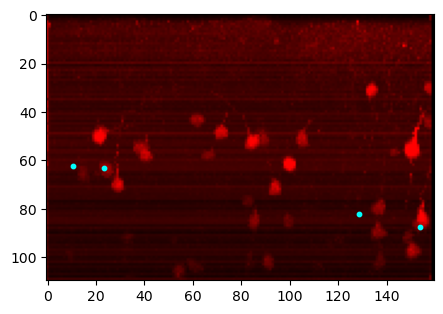

In [30]:

plt.figure(figsize = (5,5));plt.imshow(gray2RGB(data.transpose(1,0,2),'r',scl=.6), aspect = 'equal')
plt.scatter(hp[:,2],hp[:,0], color='cyan', s = 10)


# 5. save the results as csv files

In [25]:
import pandas as pd 

pd.DataFrame(hp, columns = ['Z',"X",'Y'])

,Z,X,Y
0,62.349355,-0.600362,10.313760
1,63.314858,29.346971,23.344350
2,81.945655,79.249047,128.733489
3,87.413767,2.980940,153.863873


In [35]:
base_dir = '/Users/shuonan/Downloads/'
pd.DataFrame(hp, columns = ['Z',"X",'Y']).to_csv(base_dir+f'found_spot_{filenames[i]}.csv', sep='\t')